In [1]:
import pandas as pd
import os

# 1. 병합할 경로 지정
base_path = "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/8.성과정보"
months = ['07', '08', '09', '10', '11', '12']
file_paths = [os.path.join(base_path, f"2018{month}_train_성과정보.parquet") for month in months]

# 2. 병합 리스트
df_list = []
for path in file_paths:
    df = pd.read_parquet(path)
    df['기준년월'] = os.path.basename(path).split('_')[0]  # 기준년월 컬럼 추가
    df_list.append(df)

# 3. 병합 수행
merged_df = pd.concat(df_list, ignore_index=True)

# 4. 결과 확인
print("병합된 데이터프레임 크기:", merged_df.shape)
print("컬럼 목록:")
print(merged_df.columns.tolist())

병합된 데이터프레임 크기: (2400000, 49)
컬럼 목록:
['기준년월', 'ID', '증감율_이용건수_신용_전월', '증감율_이용건수_신판_전월', '증감율_이용건수_일시불_전월', '증감율_이용건수_할부_전월', '증감율_이용건수_CA_전월', '증감율_이용건수_체크_전월', '증감율_이용건수_카드론_전월', '증감율_이용금액_신용_전월', '증감율_이용금액_신판_전월', '증감율_이용금액_일시불_전월', '증감율_이용금액_할부_전월', '증감율_이용금액_CA_전월', '증감율_이용금액_체크_전월', '증감율_이용금액_카드론_전월', '증감율_이용건수_신용_분기', '증감율_이용건수_신판_분기', '증감율_이용건수_일시불_분기', '증감율_이용건수_할부_분기', '증감율_이용건수_CA_분기', '증감율_이용건수_체크_분기', '증감율_이용건수_카드론_분기', '증감율_이용금액_신용_분기', '증감율_이용금액_신판_분기', '증감율_이용금액_일시불_분기', '증감율_이용금액_할부_분기', '증감율_이용금액_CA_분기', '증감율_이용금액_체크_분기', '증감율_이용금액_카드론_분기', '잔액_신판평균한도소진율_r6m', '잔액_신판최대한도소진율_r6m', '잔액_신판평균한도소진율_r3m', '잔액_신판최대한도소진율_r3m', '잔액_신판ca평균한도소진율_r6m', '잔액_신판ca최대한도소진율_r6m', '잔액_신판ca평균한도소진율_r3m', '잔액_신판ca최대한도소진율_r3m', '변동률_일시불평잔', '변동률_RV일시불평잔', '변동률_할부평잔', '변동률_CA평잔', '변동률_RVCA평잔', '변동률_카드론평잔', '변동률_잔액_B1M', '변동률_잔액_일시불_B1M', '변동률_잔액_CA_B1M', '혜택수혜율_R3M', '혜택수혜율_B0M']


In [2]:
from sklearn.preprocessing import LabelEncoder

# 1. 복사본 생성 (원본 보존하고 싶을 경우)
encoded_df = merged_df.copy()

# 2. 문자형 컬럼을 Label Encoding
for col in encoded_df.columns:
    if encoded_df[col].dtype == 'object' or encoded_df[col].dtype.name == 'category':
        encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col].astype(str))

# 3. 확인
print("문자형 → 수치형 변환 완료")
print("변환된 데이터 타입:")
print(encoded_df.dtypes.value_counts())

문자형 → 수치형 변환 완료
변환된 데이터 타입:
float64    47
int32       2
Name: count, dtype: int64


In [3]:
# 1. 표준편차 0인 컬럼 제거
std_0_cols = encoded_df.columns[encoded_df.std() == 0].tolist()
print("표준편차 0인 컬럼:", std_0_cols)
encoded_df = encoded_df.drop(columns=std_0_cols)

# 2. 결측치 비율 30% 이상 컬럼 제거
null_ratio = encoded_df.isnull().mean()
high_null_cols = null_ratio[null_ratio > 0.3].index.tolist()
print("결측치 비율 > 30% 컬럼:", high_null_cols)
encoded_df = encoded_df.drop(columns=high_null_cols)

# 3. 결과 요약
print("✅ 정리된 컬럼 수:", encoded_df.shape[1])

표준편차 0인 컬럼: []
결측치 비율 > 30% 컬럼: []
✅ 정리된 컬럼 수: 49


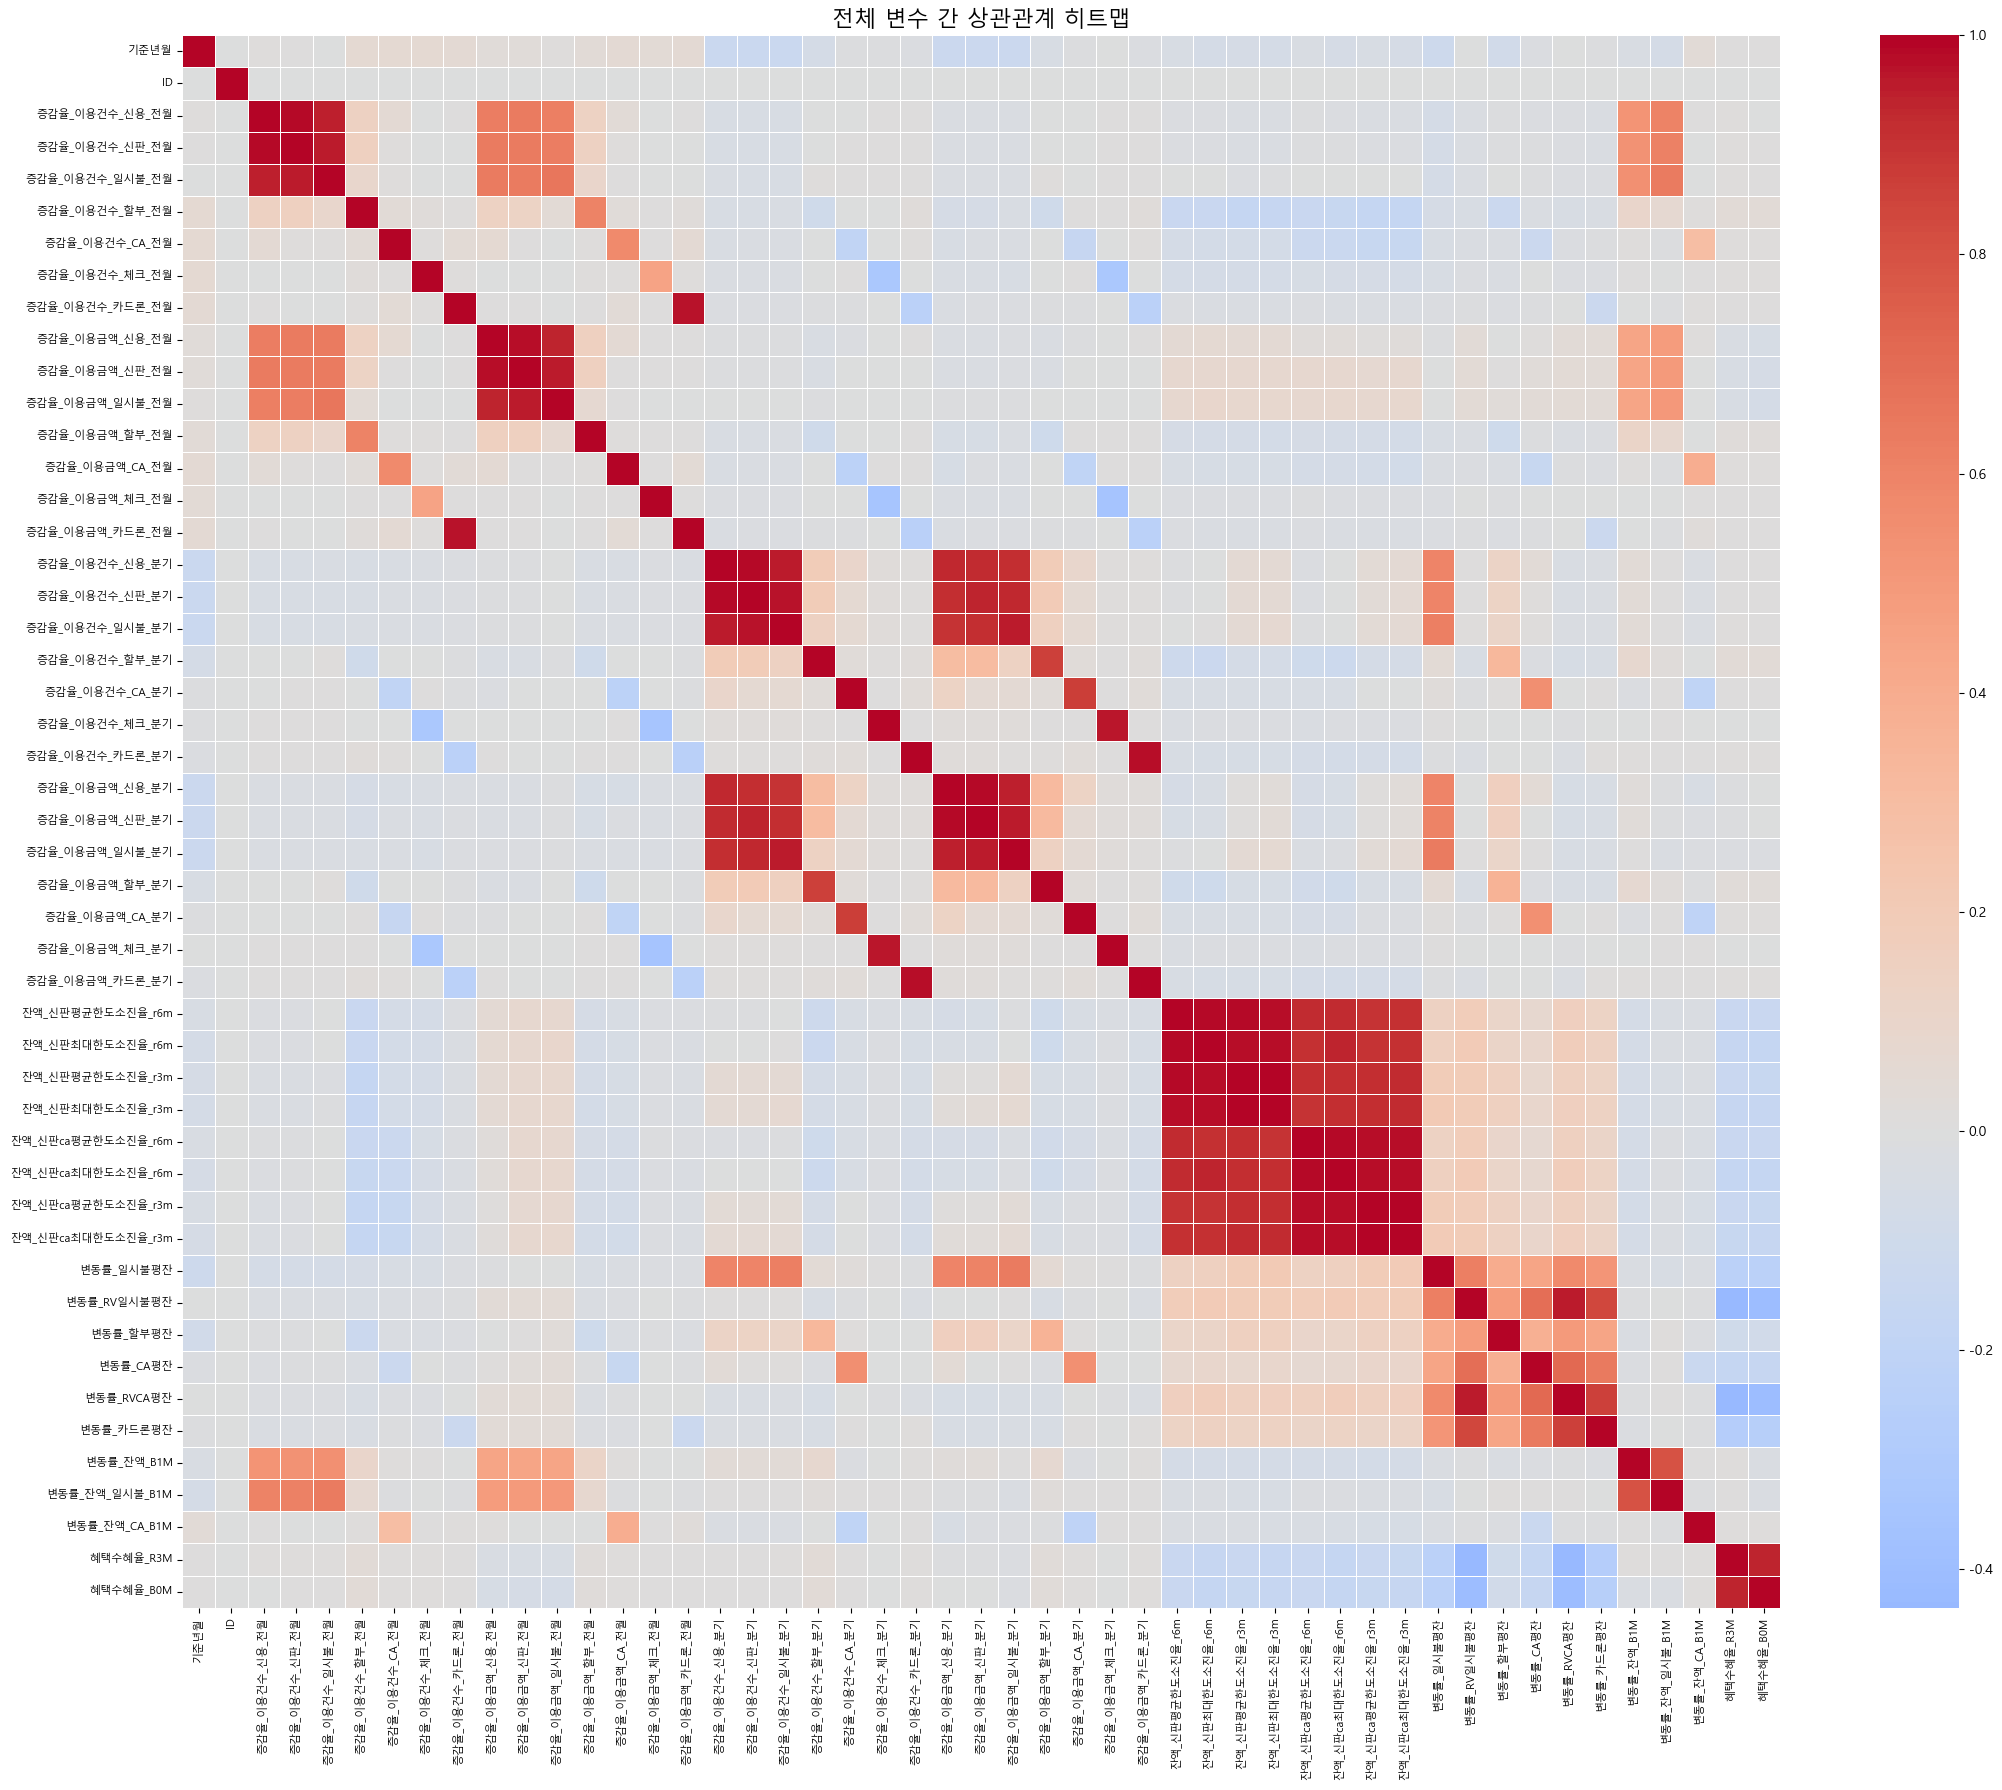

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 1. 상관계수 계산
corr_matrix = encoded_df.corr()

# 2. 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# 3. 히트맵 시각화
plt.figure(figsize=(22, 18))  # 넓고 크게
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=False,
    cbar=True,
    linewidths=0.5
)

plt.title("전체 변수 간 상관관계 히트맵", fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [5]:
# 1. 절댓값 기준으로 상관계수 추출
threshold = 0.5
corr_pairs = corr_matrix.abs().unstack()

# 2. 자기 자신과의 상관 (항상 1) 제거
corr_pairs = corr_pairs[corr_pairs < 1]

# 3. 중복 쌍 제거 (A-B, B-A)
corr_pairs = corr_pairs.drop_duplicates()

# 4. 0.5 이상 필터링
strong_corr = corr_pairs[corr_pairs >= threshold].sort_values(ascending=False)

# 5. 결과 확인
print("상관계수 0.5 이상인 변수쌍 개수:", strong_corr.shape[0])
print(strong_corr)

상관계수 0.5 이상인 변수쌍 개수: 91
잔액_신판평균한도소진율_r3m    잔액_신판최대한도소진율_r3m      0.994910
잔액_신판ca평균한도소진율_r3m  잔액_신판ca최대한도소진율_r3m    0.994069
증감율_이용건수_신용_전월      증감율_이용건수_신판_전월        0.988043
증감율_이용건수_신용_분기      증감율_이용건수_신판_분기        0.986543
잔액_신판ca평균한도소진율_r6m  잔액_신판ca최대한도소진율_r6m    0.986143
                                            ...   
증감율_이용건수_일시불_전월     변동률_잔액_B1M            0.543293
증감율_이용건수_신판_전월      변동률_잔액_B1M            0.531178
증감율_이용건수_신용_전월      변동률_잔액_B1M            0.527627
변동률_일시불평잔           변동률_카드론평잔             0.513557
증감율_이용금액_일시불_전월     변동률_잔액_일시불_B1M        0.504446
Length: 91, dtype: float64


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

# 윈도우 사용자용 - Malgun Gothic 설치돼 있다고 가정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 말굿고딕 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

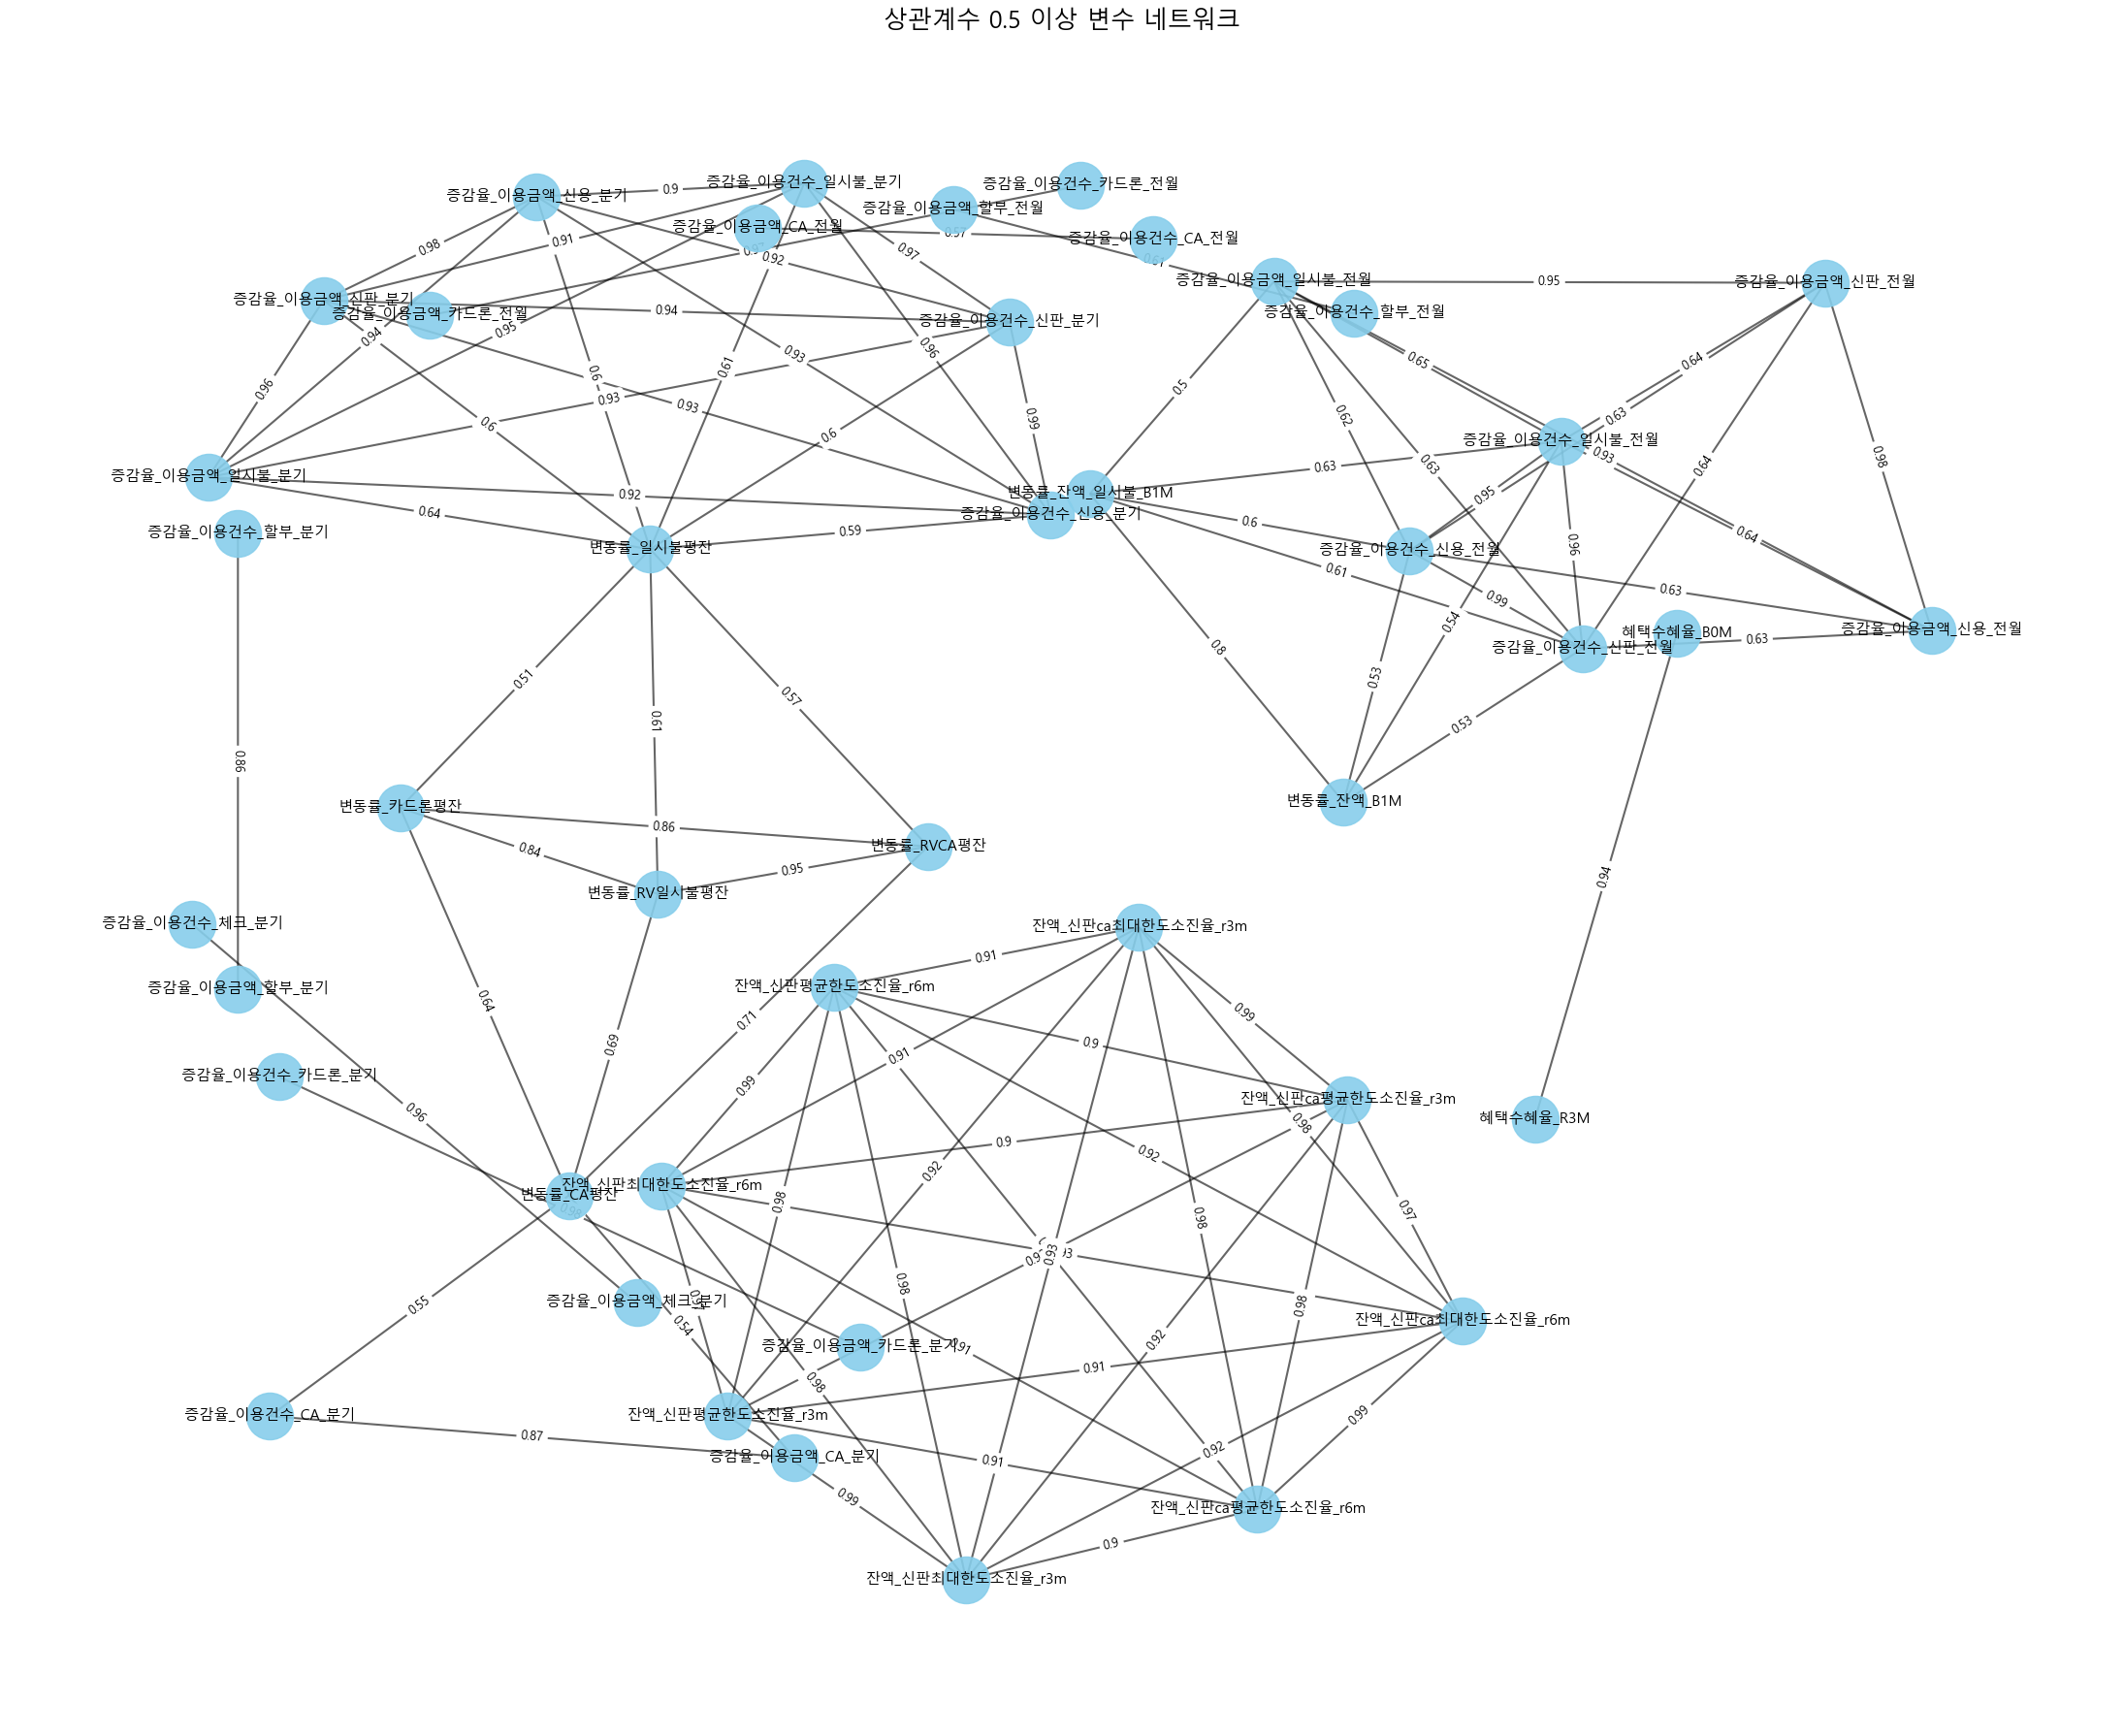

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

# 1. 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_prop
mpl.rcParams['axes.unicode_minus'] = False

# 2. 상관계수 0.5이상 페어 추출
threshold = 0.5
corr_pairs = corr_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()
strong_corr = corr_pairs[corr_pairs >= threshold]

# 3. 그래프 생성
G = nx.Graph()
for (var1, var2), corr in strong_corr.items():
    G.add_edge(var1, var2, weight=round(corr, 2))

# 4. 가독성 향상: 배치 조정, 폰트/간격 확대
plt.figure(figsize=(22, 18))
pos = nx.kamada_kawai_layout(G)  # 🔸 거리 기반 균형 배치

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color='skyblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)

# 텍스트 가독성 개선
nx.draw_networkx_labels(G, pos, font_size=11, font_family=font_prop)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_family=font_prop)

plt.title("상관계수 0.5 이상 변수 네트워크", fontsize=18, fontname=font_prop)
plt.axis('off')
plt.tight_layout()
plt.show()